# Diarization Dataset Evaluation
Authors: Dade Wood | daw1882@rit.edu, Wiley Matthews | wsm8855@rit.edu

This notebook demonstrates the process of evaluating the `pyannote.audio` speaker diarization model on one of our generated datasets.

## Setup
- Link the colab to the shared drive
- Install the `pyannote.audio` package
- Login to Hugging Face

### Link to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install `pyannote.audio`

In [2]:
!pip install pyannote.audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import requirements

In [3]:
# import packages for data manipulation
from glob import glob
import os

# import our module for RTTM files
import sys
sys.path.insert(0,'/content/drive/Shareddrives/Data-Analytics/')
import rttm

# import relevant pyannote.core data structures and constants
from pyannote.core.annotation import Annotation, PYANNOTE_SEGMENT, PYANNOTE_TRACK, PYANNOTE_LABEL
from pyannote.core.segment import Segment

# import evaluation metric
from pyannote.metrics.diarization import DiarizationErrorRate

# import login and pipeline
from huggingface_hub import notebook_login
from pyannote.audio import Pipeline

### Login to Hugging Face

This is required to use the model because one must accept the terms and conditions to use it.

To create and account and accept user conditions (only if requested):
- Create a Hugging Face account at [huggingface.co/](https://huggingface.co/) (if you do not already have one)
- Accept the user conditions at these two pages
  - [hf.co/pyannote/speaker-diarization](hf.co/pyannote/speaker-diarization)
  - [hf.co/pyannote/segmentation](hf.co/pyannote/segmentation)
- Create an access token at [hf.co/settings/tokens](hf.co/settings/tokens)

When the following cell is executed, a prompt will appear asking for a password. The password is the token generated using the steps above.

In [4]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


### Helper functions

In [7]:
def annotation_from_rttm_file(fn_rttm):
    """
    Load the data in an RTTM file  to pyannote's Annotation data structure.
    The Annotation data structure is compatible with the 
    DiarizationErrorRate metric for comparison with the model's predictions.
    """

    # read raw rttm entries into our format
    rttms = []
    with open(fn_rttm, 'r') as rttm_file:
        for line in rttm_file:
            rttms.append(rttm.file_str2rttm(line))

    # into df for easy handling and handoff to pyannote
    df = rttm.rttms2df(rttms)

    # convert into pyannote's types
    def to_segment(row):
        return Segment(row['turn_onset'], row['turn_duration']+row['turn_onset'])
    df[PYANNOTE_SEGMENT] = df[['turn_onset', 'turn_duration']].apply(to_segment, axis=1)
    df[PYANNOTE_TRACK] = df['file_id'].apply(lambda fid: fid)
    df[PYANNOTE_LABEL] = df['speaker_name'].apply((lambda name: name))

    # pyannote does the rest
    annotation = Annotation.from_df(df)
    return annotation


def evaluate_dataset(audio_dir, rttm_dir, model):
    """Return average DER of the model on given dataset"""
    # Set eval method
    eval = DiarizationErrorRate()

    # Gather files
    audio_files = glob(os.path.join(audio_dir, "*.wav"))
    audio_files.sort()
    rttm_files = glob(os.path.join(rttm_dir, "*.rttm"))
    rttm_files.sort()

    # Process files
    errors = []
    for audio, rttm in zip(audio_files, rttm_files):
        diarization = model(audio)
        label_annotation = annotation_from_rttm_file(rttm)
        error = eval(reference=label_annotation, hypothesis=diarization)
        print(f'DER for {os.path.basename(audio)}: {error*100:.2f}%')
        errors.append(error)
    return sum(errors) / len(errors)


## Diarization Example (one file)

The following cells define an example audio file and evaluate the diarization model on it.

In [8]:
wav = "/content/drive/Shareddrives/Data-Analytics/sample_1.wav"

In [9]:
# Apply pretrained pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)
diarization = pipeline(wav)

# Print the results
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=0.5s stop=2.2s speaker_SPEAKER_00
start=2.7s stop=5.9s speaker_SPEAKER_02
start=5.9s stop=9.5s speaker_SPEAKER_01


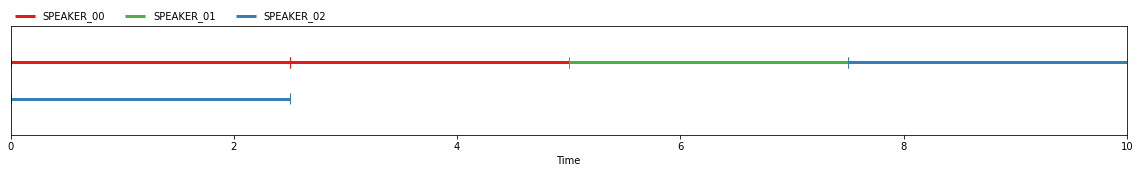

In [10]:
# Display labeled data
fn_rttm = "/content/drive/Shareddrives/Data-Analytics/sample_0.rttm"
label_annotation = annotation_from_rttm_file(fn_rttm)
label_annotation

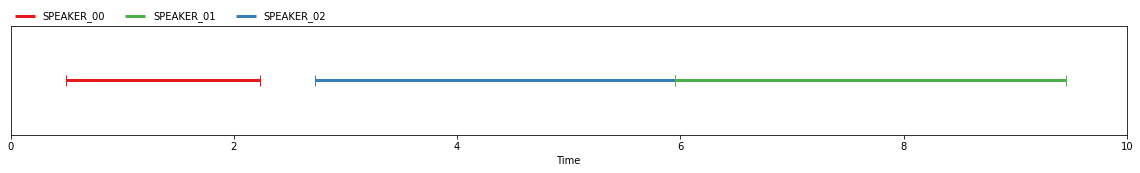

In [11]:
# Display predicted data
diarization

In [12]:
# Compute DER
der = DiarizationErrorRate()
print(der.compute_components(reference=label_annotation, hypothesis=diarization))
print(der(reference=label_annotation, hypothesis=diarization))

{'correct': 5.564374999999999, 'false alarm': 0.0, 'total': 12.5, 'confusion': 2.906875000000003, 'missed detection': 4.028749999999998}
0.5548500000000001


## Experimentation with Evaluation

The following cells define some helper functions, then load the dataset and apply the model to it.

### Apply the model

This example applies the model to a test dataset. Change the audio and rttm directories to whichever dataset you want to use.

In [13]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)
DER = evaluate_dataset(
    audio_dir='/content/drive/Shareddrives/Data-Analytics/dataset_d/audio',
    rttm_dir='/content/drive/Shareddrives/Data-Analytics/dataset_d/rttm',
    model=pipeline
)
print(f'Average DER for dataset: {DER*100:.2f}%')

DER for sample_0.wav: 21.63%
DER for sample_1.wav: 41.59%
DER for sample_10.wav: 27.62%
DER for sample_11.wav: 27.67%
DER for sample_12.wav: 48.03%
DER for sample_13.wav: 60.51%
DER for sample_14.wav: 50.87%
DER for sample_15.wav: 41.27%
DER for sample_16.wav: 36.25%
DER for sample_17.wav: 36.92%
DER for sample_18.wav: 72.69%
DER for sample_19.wav: 52.46%
DER for sample_2.wav: 29.08%
DER for sample_20.wav: 26.32%
DER for sample_21.wav: 16.91%
DER for sample_22.wav: 39.36%
DER for sample_23.wav: 17.45%
DER for sample_24.wav: 52.35%
DER for sample_25.wav: 39.88%
DER for sample_26.wav: 37.25%
DER for sample_27.wav: 51.29%
DER for sample_28.wav: 29.84%
DER for sample_29.wav: 52.53%
DER for sample_3.wav: 84.41%
DER for sample_30.wav: 41.61%
DER for sample_31.wav: 32.76%
DER for sample_32.wav: 49.22%
DER for sample_33.wav: 43.67%
DER for sample_34.wav: 36.48%
DER for sample_35.wav: 37.69%
DER for sample_36.wav: 56.15%
DER for sample_37.wav: 60.44%
DER for sample_38.wav: 20.76%
DER for sample